## Filtering an audio signal

We've seen that if we know the impulse response of a linear time-invariant (LTI) discrete-time system, then we can obtain the output of that system by convolving its impulse response with any input signal. This is the mathematical operation we perform when we say that we are "filtering a signal". We also know that our fundamental representation of audio signals is via the complex exponential. So if we consider the complex exponential as the input signal, then we can gain some more insight into what we are actually doing when we filter audio signals. Let's explore that in this notebook.

In [ ]:
# Import the necessary packages as usual
%pip install ipympl
import numpy as np 
import scipy as sp
from scipy import signal
from matplotlib import pyplot as plt
from ipywidgets import * # interactive plots
import IPython
from IPython.display import Audio, Image
%matplotlib ipympl

### Eigenfunctions of LTI systems.

Let's consider the LTI discrete-time system in Fig. 1 with impulse response, $h[n]$ and a discrete-time complex exponential input $x[n] = e^{j\omega n T_{s}}$, where $\omega$ is the angular frequency (rad/s) and $T_{s}$ is the sampling period (seconds). 
<br>

<div>
<center> <img src="LTI_compexp.png" width="450"/> <center/>
    <p style="text-align:center">Fig. 1 - Complex exponential input to an LTI system. </p>
</div>

<br>

We can obtain the output of this system by convolving $h[n]$ with $x[n]$ as follows:
$\begin{align} 
y[n] &= \sum_{k=-\infty}^{k=\infty} h[k] x[n-k] \\
      &= \sum_{k=-\infty}^{k=\infty} h[k] e^{j \omega (n-k) T_{s}}\\
      &= \sum_{k=-\infty}^{k=\infty} h[k] e^{j \omega n T_{s}} e^{-j \omega k T_{s}} \\
      &= e^{j \omega n T_{s}} \underbrace{\sum_{k=-\infty}^{k=\infty} h[k]  e^{-j \omega k T_{s}}}_{H(e^{j\omega T_s}) \text{: DTFT of } h[n]}
\end{align}$

where we recognize that the input, $e^{j \omega n T_{s}}$ is simply multiplied by the discrete-time Fourier transform (DTFT) of the impulse response of the LTI system, $h[n]$ (i.e., the transfer function of the LTI system). And because we can express the transfer function in terms of its magnitude and phase, we can express the output of the system as:

$\begin{align}
y[n] &= H(e^{j \omega T_{s}})  \hspace{0.1cm} e^{j \omega n T_{s}} \\
     &= |H(e^{j \omega T_{s}})| \hspace{0.1cm} e^{j\phi_{H}} \hspace{0.1cm} e^{j \omega n T_{s}} \\
     &= |H(e^{j \omega T_{s}})| \hspace{0.1cm} \hspace{0.1cm} e^{j (\omega n T_{s}+\phi_{H})}
\end{align}$

where $|H(e^{j \omega T_{s}})|$ is the magnitude of $H(e^{j \omega T_{s}})$ and $\phi_{H}$ is its phase. 

Hence the output of an LTI system to a complex exponential is simply another complex exponential, but just scaled by a complex number, i.e., the magnitude and phase of the LTI system’s frequency response. For this reason the complex exponential is regarded as an **eigenfunction** of an LTI system. In general, an **eigenfunction** of a linear system is a function of time (i.e. a signal) such that, when passed through the system, results in an output that is equal to the original function multiplied by a constant, and in our case the constant is simply the complex number $H(e^{j \omega T_{s}})$.


### A sinusoidal input

Let's consider now the discrete-time input, $x[n] = \cos(\omega n T_s)$. Recall that this can simply be expressed as a sum of complex exponentials using Euler's identity:

$\begin{equation}
\cos(\omega n T_s) = \frac{1}{2}\left(e^{j\omega n T_s} + e^{-j\omega n T_s}\right)
\end{equation}$

Using the previous derived result for complex exponentials, it is straightforward to show that the output of the LTI system is given by

$\begin{align}
y[n] &= H(e^{j \omega T_{s}})  \hspace{0.1cm} \cos(\omega n T_s) \\
     &= |H(e^{j \omega T_{s}})| \hspace{0.1cm} \cos(\omega n T_s+\phi_{H})
\end{align}$

This is a pretty remarkable result as it shows that a cosine is also produced at the output, except that (i) it has been scaled by the magnitude of the LTI system frequency response and (ii) it’s phase has changed by the phase of the LTI system frequency response. And that's essentially all we are doing when we are filtering audio signals! Simply modifying the magnitude and phase at different frequencies according to the transfer function of the LTI system. 

Let's have a more tangible view of this. We'll consider a simple LTI system that is a notch filter and an input cosine. The first plot shows the transfer function of the notch filter (its magnitude and phase). The second plot shows the time-domain waveforms of the input and output signals from the system. Change the frequency of the cosine in the following plot and observe the magnitude and phase changes in the output signal. 

Move the slider to see how the parameters change the cosine and listen to the result


interactive(children=(IntSlider(value=500, description='f_input', max=4000, min=500), Output()), _dom_classes=…

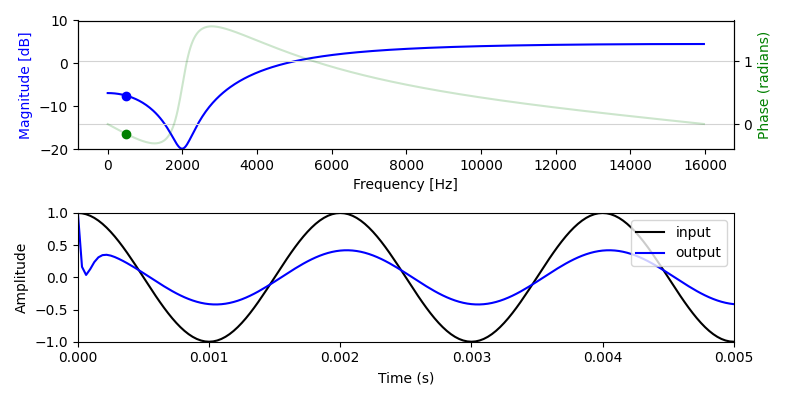

In [22]:
# Don't worry so much about this part of the code - it's just to set up a filter (it will become clearer when we look at the Z-transform later)
## Design the filter and plot the response
fs = 32000 # sampling freq (Hz)

# These are the filter coefficients for a biquad filter (will make a resonance or notch):
fo = 2000 # centre freq to be a notch/boost
omega = (2*np.pi*fo)/fs
# make zeta > rho for notch; rho > zeta for resonance (don't go above 1!)
zeta = 0.95
rho = 0.5

b1 = -2*zeta*np.cos(omega)
b2 = zeta**2
a1 = -2*rho*np.cos(omega)
a2 = rho**2
bo = 1; ao = 1;

b =[bo,b1,b2]
a =[ao, a1, a2]

w, h = signal.freqz(b,a)
freq_axis = w*((fs/2)/np.pi)
angles = np.unwrap(np.angle(h))

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx, array[idx]

t = np.arange(0,2,1/fs)

# Setting up the plots
fig, axes = plt.subplots(2,1, figsize=(8, 4))
linelms, = axes[0].plot(freq_axis, 20 * np.log10(abs(h)), 'b-')
scat_pt, = axes[0].plot(0, 0, 'bo')
axes[0].set_ylabel('Magnitude [dB]', color='b')
axes[0].set_xlabel('Frequency [Hz]')
axes[0].set_ylim([-20, 10])
ax2 = axes[0].twinx()
linephlms, = ax2.plot(freq_axis, angles, 'g-',alpha=0.2)
scat_pt_phase, = ax2.plot(0, 0, 'go')
ax2.set_ylabel('Phase (radians)', color='g')
ax2.grid(True,color='lightgrey')
ax2.axis('tight')

line, = axes[1].plot([], [], 'k',label='input')
line_out, = axes[1].plot([], [], 'b',label='output')
axes[1].set_ylabel('Amplitude', color='k')
axes[1].set_xlabel('Time (s)', color='k')
axes[1].set_xlim([0, 0.005])
axes[1].set_ylim([-1, 1])
axes[1].legend(loc='upper right')


# Create the interactive plot
def update(f_input = 500):
    
    fig.canvas.draw_idle()

    xn = np.cos(2*np.pi*f_input*t) # sinusoidal input
    line.set_data(t, xn)
    
    yn = signal.lfilter(b, a, xn)
    line_out.set_data(t, yn)
    
    # finding the point on filter
    [idx, val] = find_nearest(freq_axis, value=f_input)
    scat_pt.set_data([freq_axis[idx], -10], [20*np.log10(abs(h[idx])), -60])
    scat_pt_phase.set_data([freq_axis[idx], -10], [angles[idx], -60])
    
    print('INPUT:')
    IPython.display.display(Audio(xn.T, rate=fs,normalize=False))

    print('OUTPUT:')
    IPython.display.display(Audio(yn.T, rate=fs,normalize=False))

plt.tight_layout()

print('Move the slider to see how the parameters change the cosine and listen to the result')
interact(update, f_input=(500,4000,1)); 

